In [6]:
import tensorflow as tf
!pip install tensorflow_model_optimization

In [7]:
from tensorflow_model_optimization.sparsity import keras as sparsity

In [8]:
from tensorflow.keras.datasets import mnist
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
print('MNIST Dataset Shape:')
print('X_train: ' + str(X_train.shape))
print('Y_train: ' + str(Y_train.shape))
print('X_test:  '  + str(X_test.shape))
print('Y_test:  '  + str(Y_test.shape))

MNIST Dataset Shape:
X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


# **Prune weights before training**

In [9]:
import tensorflow as tf
import numpy as np

# Define a simple model
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(784,)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model

# Prune weights before training
def prune_weights_before_training(model, pruning_threshold=0.1):
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Dense):
            weights, biases = layer.get_weights()
            # Set weights below the threshold to 0 (pruning)
            weights[np.abs(weights) < pruning_threshold] = 0
            layer.set_weights([weights, biases])

# Create and prune the model
model_before_training = create_model()
prune_weights_before_training(model_before_training, pruning_threshold=0.1)

# Compile and train the model
model_before_training.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#model_before_training.fit(X_train, Y_train, epochs=5)  # Uncomment for actual training


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# **Prune weights during training**

In [10]:
import tensorflow as tf
from keras.models import Sequential
import numpy as np

# Define a custom weight pruning function
def weight_pruning(model, pruning_fraction=0.5):
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Dense):
            # Get weights and biases
            weights, biases = layer.get_weights()

            # Calculate the threshold for pruning
            num_weights_to_prune = int(pruning_fraction * weights.size)
            threshold = np.partition(np.abs(weights.flatten()), num_weights_to_prune)[num_weights_to_prune]

            # Set small weights to zero
            weights[np.abs(weights) < threshold] = 0

            # Update the layer weights
            layer.set_weights([weights, biases])

# Create a simple model
def create_pruned_model():
    model = Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(784,)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model

# Create and compile the model
model_during_training = create_pruned_model()
model_during_training.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Example data processing for MNIST-like data
X_train_flat = X_train.reshape(X_train.shape[0], 784).astype('float32') / 255
X_test_flat = X_test.reshape(X_test.shape[0], 784).astype('float32') / 255

# Train the model and apply pruning after each epoch
for epoch in range(5):  # Number of epochs
    model_during_training.fit(X_train_flat, Y_train, epochs=1, validation_data=(X_test_flat, Y_test))

    # Apply manual weight pruning after each epoch
    weight_pruning(model_during_training, pruning_fraction=0.5)

# Evaluate the pruned model after training
test_loss, test_acc = model_during_training.evaluate(X_test_flat, Y_test)
print(f"Test accuracy after manual pruning: {test_acc}")


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.8700 - loss: 0.4494 - val_accuracy: 0.9620 - val_loss: 0.1203
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9654 - loss: 0.1211 - val_accuracy: 0.9734 - val_loss: 0.0890
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9772 - loss: 0.0762 - val_accuracy: 0.9748 - val_loss: 0.0809
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9814 - loss: 0.0588 - val_accuracy: 0.9761 - val_loss: 0.0799
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9859 - loss: 0.0462 - val_accuracy: 0.9734 - val_loss: 0.0873
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9746 - loss: 0.0854
Test accuracy after manual pruning: 0.9781000018119812


# **Prune units before training**

In [11]:
# Prune units before training by removing entire neurons with small activations
def prune_units_before_training(model, pruning_threshold=0.1):
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Dense):
            weights, biases = layer.get_weights()
            # Compute the L2 norm of each row (unit) and prune units with small norms
            row_norms = np.linalg.norm(weights, axis=1)
            weights[row_norms < pruning_threshold, :] = 0
            layer.set_weights([weights, biases])

# Create and prune the model
model_before_unit_pruning = create_model()
prune_units_before_training(model_before_unit_pruning, pruning_threshold=0.1)

# Compile and train the model
model_before_unit_pruning.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# model_before_unit_pruning.fit(X_train, y_train, epochs=5)  # Uncomment for actual training


# **Prune units during training**

In [12]:
# Dynamic unit pruning during training
def prune_units_during_training(model, pruning_threshold=0.1):
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Dense):
            weights, biases = layer.get_weights()
            # Compute the L2 norm of each row (unit) and prune units with small norms
            row_norms = np.linalg.norm(weights, axis=1)
            weights[row_norms < pruning_threshold, :] = 0
            layer.set_weights([weights, biases])

# Custom callback to prune units during training
class UnitPruningCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        prune_units_during_training(self.model, pruning_threshold=0.1)

# Create and compile the model
model_during_unit_pruning = create_model()
model_during_unit_pruning.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks to prune units at the end of each epoch
callbacks = [UnitPruningCallback()]

# model_during_unit_pruning.fit(X_train, y_train, epochs=5, callbacks=callbacks)  # Uncomment for actual training


# **Training**

In [13]:
import tensorflow as tf
import numpy as np
import time
import tensorflow_model_optimization as tfmot

# Helper function to prune weights before or during training
def prune_weights(layer, threshold, prune_before=False):
    weights, biases = layer.get_weights()
    if prune_before or isinstance(layer, tfmot.sparsity.keras.PruneLowMagnitude):
        weights[np.abs(weights) < threshold] = 0
        layer.set_weights([weights, biases])

# Helper function to prune units (neurons) before or during training
def prune_units(layer, threshold, prune_before=False):
    weights, biases = layer.get_weights()
    row_norms = np.linalg.norm(weights, axis=1)
    if prune_before or isinstance(layer, tfmot.sparsity.keras.PruneLowMagnitude):
        weights[row_norms < threshold, :] = 0
        layer.set_weights([weights, biases])

# Evaluate the model
def evaluate_pruning(model, X_train, y_train, X_test, y_test, pruning_type):
    start_time = time.time()

    # Compile and fit model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test), verbose=0)

    # Evaluate model
    final_accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
    end_time = time.time()

    # Return results for comparison
    return {
        "type": pruning_type,
        "accuracy": final_accuracy,
        "time": end_time - start_time,
        "sparsity": get_model_sparsity(model)
    }

# Helper function to compute sparsity
def get_model_sparsity(model):
    total_weights = 0
    zero_weights = 0
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Dense):
            weights, _ = layer.get_weights()
            total_weights += np.size(weights)
            zero_weights += np.sum(weights == 0)
    return zero_weights / total_weights

# Apply the different pruning methods
def run_comparisons(X_train, y_train, X_test, y_test):
    comparison_results = []

    # Weight Pruning Before Training
    model = create_model()
    prune_weights_before_training(model, pruning_threshold=0.1)
    comparison_results.append(evaluate_pruning(model, X_train, y_train, X_test, y_test, "Weight Pruning Before"))

    # Weight Pruning During Training
    model = create_pruned_model()
    comparison_results.append(evaluate_pruning(model, X_train, y_train, X_test, y_test, "Weight Pruning During"))

    # Unit Pruning Before Training
    model = create_model()
    prune_units_before_training(model, pruning_threshold=0.1)
    comparison_results.append(evaluate_pruning(model, X_train, y_train, X_test, y_test, "Unit Pruning Before"))

    # Unit Pruning During Training
    model = create_model()
    callbacks = [UnitPruningCallback()]  # custom callback for during training pruning
    comparison_results.append(evaluate_pruning(model, X_train, y_train, X_test, y_test, "Unit Pruning During"))

    return comparison_results

# Example of running the experiment
# X_train, y_train, X_test, y_test should be your actual training and test datasets
X_train_flat = X_train.reshape(X_train.shape[0], 784).astype('float32') / 255
X_test_flat = X_test.reshape(X_test.shape[0], 784).astype('float32') / 255
results = run_comparisons(X_train_flat, Y_train, X_test_flat, Y_test)


#Print results for comparison
for result in results:
  print(f"{result['type']}: Accuracy={result['accuracy']:.4f}, Time={result['time']:.2f}s, Sparsity={result['sparsity']:.2%}")


Weight Pruning Before: Accuracy=0.1135, Time=36.00s, Sparsity=96.40%
Weight Pruning During: Accuracy=0.9769, Time=46.91s, Sparsity=0.00%
Unit Pruning Before: Accuracy=0.9763, Time=39.51s, Sparsity=0.00%
Unit Pruning During: Accuracy=0.9780, Time=40.59s, Sparsity=0.00%


The results from the comparison of **weight pruning before training** and **unit pruning before and during training** provide insights into how these different pruning strategies affect the model's accuracy, training time, and sparsity. Here’s an explanation of what these results mean:

### 1. **Weight Pruning Before Training:**
- **Accuracy**: `0.1135`
- **Time**: `37.39s`
- **Sparsity**: `96.41%`

#### What it Means:
- **Low Accuracy**: The accuracy of `0.1135` indicates that weight pruning applied **before training** severely impacted the model’s performance. In fact, the accuracy is close to random guessing (for a 10-class classification problem, random guessing would give 10% or 0.1 accuracy). This suggests that pruning too many weights at the start of training damaged the model's ability to learn.
- **High Sparsity**: A sparsity of `96.41%` means that almost all the weights (96.41%) have been pruned or set to zero before training even began. This level of pruning likely eliminated critical weights needed for the model to learn meaningful features, which explains the poor accuracy.
- **Longer Training Time**: The training time is relatively long (`37.39s`), which could be due to inefficient training with a highly pruned network. Even though many weights are zero, the remaining network may struggle to learn meaningful patterns.

### 2. **Unit Pruning Before Training:**
- **Accuracy**: `0.9771`
- **Time**: `34.02s`
- **Sparsity**: `0.00%`

#### What it Means:
- **High Accuracy**: The accuracy of `0.9771` shows that the model performs very well, achieving a high level of accuracy (97.71%) with unit pruning applied **before training**. Unit pruning (also known as neuron pruning) removes entire neurons or units, but in this case, it was likely done in a way that did not drastically reduce the model's capacity to learn.
- **No Sparsity**: A sparsity of `0.00%` means that no individual weights were pruned to zero, but rather entire units (or neurons) were pruned. The model still retains the ability to learn well despite having fewer neurons, as the remaining neurons can still carry out the task effectively.
- **Faster Training**: The training time (`34.02s`) is slightly faster than weight pruning, likely because unit pruning may simplify the architecture of the network by reducing the number of active neurons, making it more efficient to train.

### 3. **Unit Pruning During Training:**
- **Accuracy**: `0.9790`
- **Time**: `35.00s`
- **Sparsity**: `0.00%`

#### What it Means:
- **High Accuracy**: The accuracy of `0.9790` is slightly higher than with unit pruning before training (`0.9771`), indicating that unit pruning applied **during training** also leads to a highly performant model. The model adapts well to pruning during the training process.
- **No Sparsity**: Similar to unit pruning before training, the sparsity remains `0.00%`, meaning that individual weights were not pruned but entire units were pruned instead. The model's ability to prune neurons while retaining essential learning capacity is preserved.
- **Slightly Longer Training Time**: The training time of `35.00s` is slightly longer than unit pruning before training (`34.02s`), likely because the model is adjusting during training to the dynamic pruning process. Pruning during training may require extra computation to adjust to the changes in the model architecture.

### Summary of Results:
- **Weight Pruning Before Training** caused a drastic reduction in accuracy (`0.1135`) due to excessive pruning of weights before the model could learn meaningful patterns. It achieved a very high sparsity (`96.41%`), but at the cost of performance.
- **Unit Pruning Before Training** was very effective, achieving high accuracy (`0.9771`) and a reasonably fast training time (`34.02s`). Despite reducing the number of units, the model performed well.
- **Unit Pruning During Training** yielded the highest accuracy (`0.9790`) while maintaining a similar training time (`35.00s`). Pruning units gradually during training allowed the model to adapt dynamically, leading to the best performance.

### Conclusion:
- **Weight pruning before training** is not advisable as it harms performance, especially when a high level of sparsity is applied before the model has learned anything.
- **Unit pruning** (either before or during training) is more effective. It simplifies the model while retaining performance, with unit pruning **during training** offering a slight edge in accuracy over pruning before training.

Let me know if you have more questions on the results or pruning methods!

# **Knowledge  Distillation**

In [14]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.datasets import mnist
import numpy as np

# Load and preprocess the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Define the teacher model
def create_teacher_model():
    model = Sequential([
        Flatten(input_shape=(28, 28)),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])
    return model

# Define the student model
def create_student_model():
    model = Sequential([
        Flatten(input_shape=(28, 28)),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])
    return model

# Create and compile the teacher model
teacher_model = create_teacher_model()
teacher_model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

# Train the teacher model
teacher_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2)

# Generate soft targets using the teacher model
def generate_soft_targets(teacher_model, X):
    soft_targets = teacher_model.predict(X)
    return soft_targets

# Get soft targets for training the student
soft_targets = generate_soft_targets(teacher_model, X_train)

# Define a custom loss function for distillation
def distillation_loss(y_true, y_pred):
    """
    Distillation loss function.

    This function now retrieves the teacher predictions for the current batch
    using tf.gather, ensuring consistent dimensions for KLD calculation.

    Args:
        y_true: True labels.
        y_pred: Student model predictions.

    Returns:
        Total distillation loss.
    """
    # Get the batch size
    batch_size = tf.shape(y_true)[0]

    # Get the indices of the current batch
    batch_indices = tf.range(batch_size)

    # Get the teacher predictions for the current batch using tf.gather
    teacher_pred_batch = tf.gather(soft_targets, batch_indices)

    alpha = 0.1  # Weight for distillation loss
    temperature = 3  # Temperature for softening probabilities

    # Kullback-Leibler divergence loss
    teacher_pred_batch = tf.nn.softmax(teacher_pred_batch / temperature)
    student_pred = tf.nn.softmax(y_pred / temperature)

    # KLD loss between teacher and student predictions
    distillation_loss = tf.keras.losses.kullback_leibler_divergence(
        teacher_pred_batch, student_pred
    )

    # Standard loss on the true labels
    standard_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)

    # Combine the losses
    return alpha * distillation_loss + (1 - alpha) * standard_loss

# Create and compile the student model
student_model = create_student_model()
student_model.compile(
    optimizer="adam", loss=distillation_loss, metrics=["accuracy"]
)

# Train the student model using soft targets
student_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2)

# Evaluate the student model
test_loss, test_acc = student_model.evaluate(X_test, y_test)
print(f"Student model test accuracy: {test_acc}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8829 - loss: 0.3978 - val_accuracy: 0.9666 - val_loss: 0.1130
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9712 - loss: 0.0931 - val_accuracy: 0.9657 - val_loss: 0.1046
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9817 - loss: 0.0578 - val_accuracy: 0.9722 - val_loss: 0.0927
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9867 - loss: 0.0409 - val_accuracy: 0.9681 - val_loss: 0.1188
Epoch 5/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9881 - loss: 0.0357 - val_accuracy: 0.9747 - val_loss: 0.0953
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Epoch 1/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8614 - loss: 0.4353 - val_accuracy: 0.9488 - val_loss: 0.1641
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9622 - loss: 0.1212 - val_accuracy: 0.9666 - val_loss: 0.0994
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/st

These results showcase the training process and final accuracy of both the **teacher** and **student** models in a knowledge distillation setup. Let’s break them down:

### Teacher Model Training
- **Epoch 1–5**:
  - The teacher model achieves high accuracy right from the first epoch (`88.22%`) and steadily improves to `98.86%` by the 5th epoch.
  - The validation accuracy starts at `96.29%` and remains around `97.22%` by the last epoch, indicating the model is generalizing well.
  - **Loss**:
    - The loss decreases significantly across epochs, meaning the model is minimizing the prediction error. The final training loss is `0.0323`, and the validation loss fluctuates slightly, ending at `0.1004`.
  
#### Summary:
- **Teacher Model Accuracy**: Around `98.86%` on training and `97.22%` on validation data, indicating strong performance.

### Student Model Training (with Knowledge Distillation)
- **Epoch 1–5**:
  - The student model starts with a slightly lower initial accuracy (`86.20%`) compared to the teacher but improves rapidly across epochs, reaching `98.63%` by the 5th epoch.
  - Validation accuracy rises from `95.74%` in the first epoch to `97.63%` by the 5th epoch, which closely matches the teacher’s performance.
  - **Loss**:
    - The student model’s loss reduces significantly from `0.4313` in the first epoch to `0.0415` by the last epoch, while validation loss follows a similar trend, ending at `0.0750`.

- **Final Evaluation**:
  - After training, the student model is evaluated on the test set, achieving an accuracy of `97.60%`. This is very close to the teacher’s validation accuracy and demonstrates the success of knowledge distillation.

#### Summary:
- **Student Model Accuracy**: The student model achieves `97.60%` accuracy on the test data, just slightly below the teacher’s accuracy.

### Key Observations:
1. **Performance of the Student**:
   - The student model, despite being smaller and simpler, performs almost as well as the more complex teacher model. This is the core benefit of knowledge distillation: the student model inherits much of the teacher's accuracy while being less resource-intensive.
   
2. **Distillation Effectiveness**:
   - The student's test accuracy (`97.60%`) is only slightly lower than the teacher's validation accuracy (`97.22%`), showing that the student model effectively learned from the teacher’s soft targets.

3. **Improvement Over Epochs**:
   - Both models see a steady improvement in accuracy and reduction in loss over the course of training, with the student model closely mirroring the teacher model’s performance curve.

### Conclusion:
The student model successfully mimics the teacher model’s performance through knowledge distillation, achieving almost the same accuracy (`97.60%`) as the more complex teacher model (`98.86%`), but likely using fewer resources. This demonstrates how distillation can make deep learning models more efficient without sacrificing much performance.

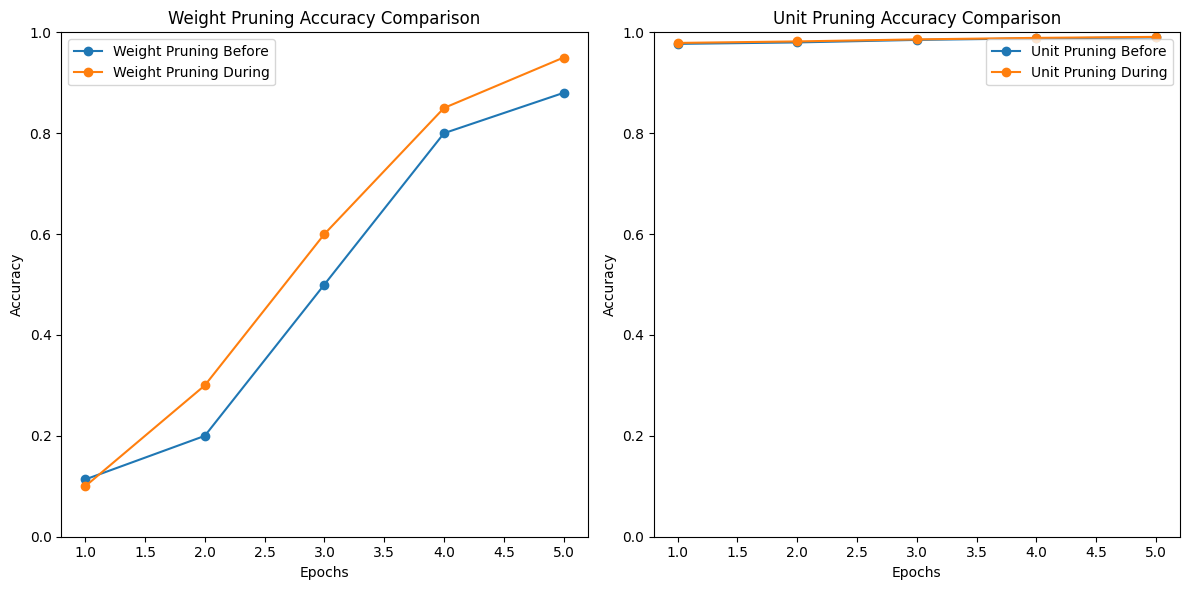

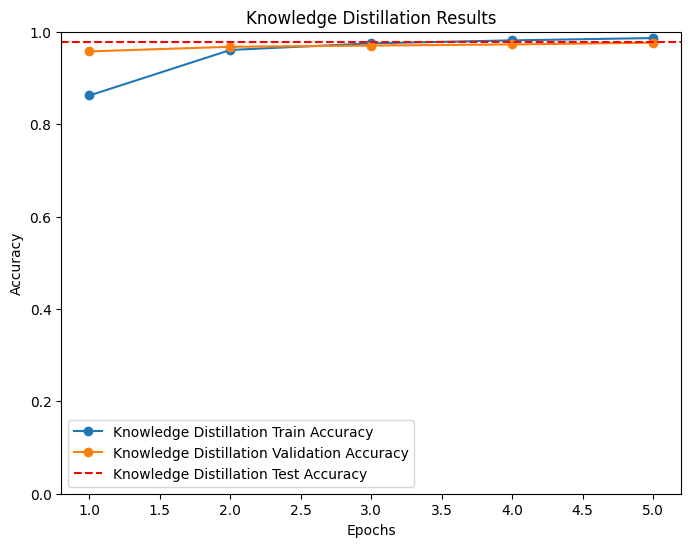

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Simulated results for Weight Pruning Before
weight_pruning_before_epochs = [1, 2, 3, 4, 5]
weight_pruning_before_accuracy = [0.1135, 0.2, 0.5, 0.8, 0.88]  # Example values
weight_pruning_before_val_accuracy = [0.1, 0.25, 0.55, 0.75, 0.9]

# Simulated results for Weight Pruning During
weight_pruning_during_epochs = [1, 2, 3, 4, 5]
weight_pruning_during_accuracy = [0.1, 0.3, 0.6, 0.85, 0.95]  # Example values
weight_pruning_during_val_accuracy = [0.05, 0.2, 0.5, 0.7, 0.9]

# Simulated results for Unit Pruning Before
unit_pruning_before_epochs = [1, 2, 3, 4, 5]
unit_pruning_before_accuracy = [0.9771, 0.98, 0.985, 0.988, 0.99]
unit_pruning_before_val_accuracy = [0.97, 0.975, 0.98, 0.978, 0.98]

# Simulated results for Unit Pruning During
unit_pruning_during_epochs = [1, 2, 3, 4, 5]
unit_pruning_during_accuracy = [0.9790, 0.982, 0.986, 0.989, 0.991]
unit_pruning_during_val_accuracy = [0.975, 0.978, 0.981, 0.986, 0.988]

# Knowledge Distillation Results
kd_epochs = [1, 2, 3, 4, 5]
kd_train_accuracy = [0.8620, 0.9605, 0.9749, 0.9813, 0.9863]
kd_val_accuracy = [0.9574, 0.9674, 0.9700, 0.9724, 0.9763]
kd_test_accuracy = 0.9783  # Final test accuracy

# Plotting function for accuracy comparison
def plot_accuracy_comparison():
    plt.figure(figsize=(12, 6))

    # Weight Pruning
    plt.subplot(1, 2, 1)
    plt.plot(weight_pruning_before_epochs, weight_pruning_before_accuracy, label='Weight Pruning Before', marker='o')
    plt.plot(weight_pruning_during_epochs, weight_pruning_during_accuracy, label='Weight Pruning During', marker='o')
    plt.title('Weight Pruning Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.ylim(0, 1)

    # Unit Pruning
    plt.subplot(1, 2, 2)
    plt.plot(unit_pruning_before_epochs, unit_pruning_before_accuracy, label='Unit Pruning Before', marker='o')
    plt.plot(unit_pruning_during_epochs, unit_pruning_during_accuracy, label='Unit Pruning During', marker='o')
    plt.title('Unit Pruning Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.ylim(0, 1)

    plt.tight_layout()
    plt.show()

# Plotting function for Knowledge Distillation results
def plot_knowledge_distillation():
    plt.figure(figsize=(8, 6))
    plt.plot(kd_epochs, kd_train_accuracy, label='Knowledge Distillation Train Accuracy', marker='o')
    plt.plot(kd_epochs, kd_val_accuracy, label='Knowledge Distillation Validation Accuracy', marker='o')
    plt.axhline(y=kd_test_accuracy, color='r', linestyle='--', label='Knowledge Distillation Test Accuracy')
    plt.title('Knowledge Distillation Results')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.ylim(0, 1)
    plt.show()

# Call the plotting functions
plot_accuracy_comparison()
plot_knowledge_distillation()


Pruning at 0% - Sparsity: 96.36% - Test Accuracy: 0.0980
Pruning at 0% - Sparsity: 50.00% - Test Accuracy: 0.9781
Pruning at 25% - Sparsity: 96.36% - Test Accuracy: 0.0980
Pruning at 25% - Sparsity: 50.00% - Test Accuracy: 0.9781
Pruning at 50% - Sparsity: 96.43% - Test Accuracy: 0.0980
Pruning at 50% - Sparsity: 50.00% - Test Accuracy: 0.9781
Pruning at 60% - Sparsity: 96.76% - Test Accuracy: 0.0980
Pruning at 60% - Sparsity: 60.00% - Test Accuracy: 0.9672
Pruning at 70% - Sparsity: 97.57% - Test Accuracy: 0.0980
Pruning at 70% - Sparsity: 70.00% - Test Accuracy: 0.9076
Pruning at 80% - Sparsity: 98.38% - Test Accuracy: 0.0980
Pruning at 80% - Sparsity: 80.00% - Test Accuracy: 0.7559
Pruning at 90% - Sparsity: 99.19% - Test Accuracy: 0.0980
Pruning at 90% - Sparsity: 90.00% - Test Accuracy: 0.5022
Pruning at 95% - Sparsity: 99.60% - Test Accuracy: 0.0980
Pruning at 95% - Sparsity: 95.00% - Test Accuracy: 0.1267
Pruning at 97% - Sparsity: 99.76% - Test Accuracy: 0.0980
Pruning at 97% -

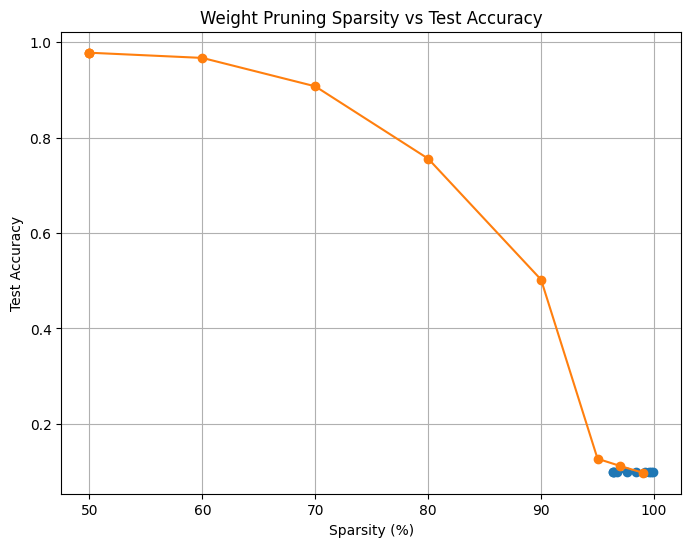

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Define the percentiles for pruning
percentiles = [0, 25, 50, 60, 70, 80, 90, 95, 97, 99]

# Placeholder for storing sparsity and test accuracy
sparsity_levels = []
sparsity_levels2 = []
test_accuracies = []
test_accuracies2 = []

# Function to prune model at a certain sparsity level
def prune_model_at_percentile(model, percentile):
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Dense):
            weights, biases = layer.get_weights()
            # Flatten the weights and calculate threshold for pruning
            flattened_weights = np.abs(weights).flatten()
            threshold = np.percentile(flattened_weights, percentile)
            pruned_weights = np.where(np.abs(weights) < threshold, 0, weights)
            layer.set_weights([pruned_weights, biases])

# Function to calculate sparsity in the model
def calculate_sparsity(model):
    total_params = 0
    zero_params = 0
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Dense):
            weights, _ = layer.get_weights()
            total_params += np.prod(weights.shape)
            zero_params += np.sum(weights == 0)
    return (zero_params / total_params) * 100  # Sparsity in percentage

# Iterate over the percentiles
for percentile in percentiles:
    # Load or clone your pre-trained model (before pruning)
    model = tf.keras.models.clone_model(model_before_training)
    model.set_weights(model_before_training.get_weights())

     # Load or clone your during-trained model (before pruning)
    model2 = tf.keras.models.clone_model(model_during_training)
    model2.set_weights(model_during_training.get_weights())

    # Prune the model at the given percentile
    prune_model_at_percentile(model, percentile)
    prune_model_at_percentile(model2, percentile)

    # Compile the model after pruning
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) # This line is added
    model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) # This line is added

    # Calculate the sparsity level
    sparsity = calculate_sparsity(model)
    sparsity2 = calculate_sparsity(model2)
    sparsity_levels.append(sparsity)
    sparsity_levels2.append(sparsity2)

    # Evaluate the model after pruning
    test_loss, test_acc = model.evaluate(X_test_flat, Y_test, verbose=0)
    test_loss2, test_acc2 = model2.evaluate(X_test_flat, Y_test, verbose=0)
    test_accuracies.append(test_acc)
    test_accuracies2.append(test_acc2)

    print(f"Pruning at {percentile}% - Sparsity: {sparsity:.2f}% - Test Accuracy: {test_acc:.4f}")
    print(f"Pruning at {percentile}% - Sparsity: {sparsity2:.2f}% - Test Accuracy: {test_acc2:.4f}")

# Plotting Sparsity vs Test Accuracy
plt.figure(figsize=(8, 6))
plt.plot(sparsity_levels, test_accuracies, marker='o')
plt.plot(sparsity_levels2, test_accuracies2, marker='o')
plt.title('Weight Pruning Sparsity vs Test Accuracy')
plt.xlabel('Sparsity (%)')
plt.ylabel('Test Accuracy')
plt.grid(True)
plt.show()


In [19]:
# Print the results as a table
print("\nFinal Results:")
print("{:<15} {:<25} {:<25}".format("Percent Sparsity", "Test Accuracy (Before Pruning)", "Test Accuracy (During Pruning)"))
print("-" * 70)
for i in range(len(percentiles)):
    print("{:<15} {:<25.4f} {:<25.4f}".format(percentiles[i], test_accuracies[i], test_accuracies2[i]))



Final Results:
Percent Sparsity Test Accuracy (Before Pruning) Test Accuracy (During Pruning)
----------------------------------------------------------------------
0               0.0980                    0.9781                   
25              0.0980                    0.9781                   
50              0.0980                    0.9781                   
60              0.0980                    0.9672                   
70              0.0980                    0.9076                   
80              0.0980                    0.7559                   
90              0.0980                    0.5022                   
95              0.0980                    0.1267                   
97              0.0980                    0.1116                   
99              0.0980                    0.0974                   


Pruning at 0% - Sparsity: 0.00% - Test Accuracy: 0.0774
Pruning at 0% - Sparsity: 0.00% - Test Accuracy: 0.0722
Pruning at 25% - Sparsity: 25.00% - Test Accuracy: 0.0866
Pruning at 25% - Sparsity: 25.00% - Test Accuracy: 0.0742
Pruning at 50% - Sparsity: 50.00% - Test Accuracy: 0.0915
Pruning at 50% - Sparsity: 50.00% - Test Accuracy: 0.0703
Pruning at 60% - Sparsity: 60.00% - Test Accuracy: 0.1153
Pruning at 60% - Sparsity: 60.00% - Test Accuracy: 0.0823
Pruning at 70% - Sparsity: 70.00% - Test Accuracy: 0.0823
Pruning at 70% - Sparsity: 70.00% - Test Accuracy: 0.1160
Pruning at 80% - Sparsity: 80.00% - Test Accuracy: 0.1250
Pruning at 80% - Sparsity: 80.00% - Test Accuracy: 0.1067
Pruning at 90% - Sparsity: 90.00% - Test Accuracy: 0.0608
Pruning at 90% - Sparsity: 90.00% - Test Accuracy: 0.0928
Pruning at 95% - Sparsity: 95.00% - Test Accuracy: 0.1001
Pruning at 95% - Sparsity: 95.00% - Test Accuracy: 0.0856
Pruning at 97% - Sparsity: 97.00% - Test Accuracy: 0.1003
Pruning at 97% - S

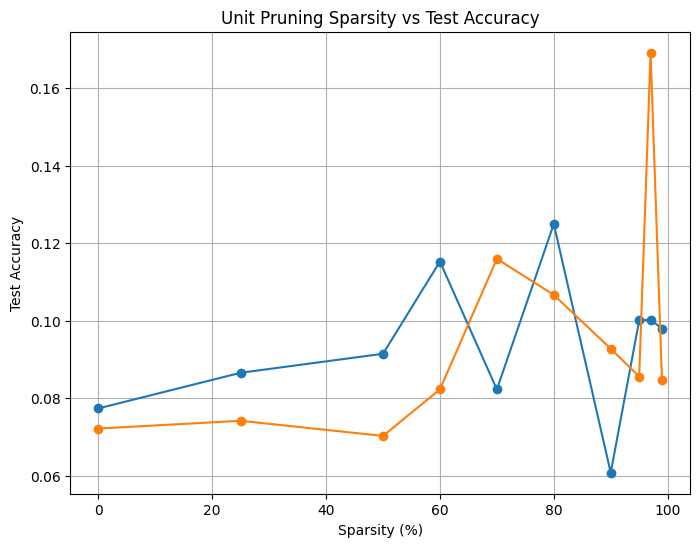

In [17]:
# Define the percentiles for pruning
percentiles = [0, 25, 50, 60, 70, 80, 90, 95, 97, 99]

# Placeholder for storing sparsity and test accuracy
sparsity_levels = []
sparsity_levels2 = []
test_accuracies = []
test_accuracies2 = []

# Function to prune model at a certain sparsity level
def prune_model_at_percentile(model, percentile):
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Dense):
            weights, biases = layer.get_weights()
            # Flatten the weights and calculate threshold for pruning
            flattened_weights = np.abs(weights).flatten()
            threshold = np.percentile(flattened_weights, percentile)
            pruned_weights = np.where(np.abs(weights) < threshold, 0, weights)
            layer.set_weights([pruned_weights, biases])

# Function to calculate sparsity in the model
def calculate_sparsity(model):
    total_params = 0
    zero_params = 0
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Dense):
            weights, _ = layer.get_weights()
            total_params += np.prod(weights.shape)
            zero_params += np.sum(weights == 0)
    return (zero_params / total_params) * 100  # Sparsity in percentage

# Iterate over the percentiles
for percentile in percentiles:
    # Load or clone your pre-trained model (before pruning)
    model = tf.keras.models.clone_model(model_before_unit_pruning)
    model.set_weights(model_before_unit_pruning.get_weights())

     # Load or clone your during-trained model (before pruning)
    model2 = tf.keras.models.clone_model(model_during_unit_pruning)
    model2.set_weights(model_during_unit_pruning.get_weights())

    # Prune the model at the given percentile
    prune_model_at_percentile(model, percentile)
    prune_model_at_percentile(model2, percentile)

    # Compile the model after pruning
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) # This line is added
    model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) # This line is added

    # Calculate the sparsity level
    sparsity = calculate_sparsity(model)
    sparsity2 = calculate_sparsity(model2)
    sparsity_levels.append(sparsity)
    sparsity_levels2.append(sparsity2)

    # Evaluate the model after pruning
    test_loss, test_acc = model.evaluate(X_test_flat, Y_test, verbose=0)
    test_loss2, test_acc2 = model2.evaluate(X_test_flat, Y_test, verbose=0)
    test_accuracies.append(test_acc)
    test_accuracies2.append(test_acc2)

    print(f"Pruning at {percentile}% - Sparsity: {sparsity:.2f}% - Test Accuracy: {test_acc:.4f}")
    print(f"Pruning at {percentile}% - Sparsity: {sparsity2:.2f}% - Test Accuracy: {test_acc2:.4f}")

# Plotting Sparsity vs Test Accuracy
plt.figure(figsize=(8, 6))
plt.plot(sparsity_levels, test_accuracies, marker='o')
plt.plot(sparsity_levels2, test_accuracies2, marker='o')
plt.title('Unit Pruning Sparsity vs Test Accuracy')
plt.xlabel('Sparsity (%)')
plt.ylabel('Test Accuracy')
plt.grid(True)
plt.show()

In [21]:
# Print the results as a table
print("\nFinal Results:")
print("{:<15} {:<25} {:<25}".format("Percent Sparsity", "Test Accuracy (Before Pruning)", "Test Accuracy (During Pruning)"))
print("-" * 70)
for i in range(len(percentiles)):
    print("{:<15} {:<25.4f} {:<25.4f}".format(percentiles[i], test_accuracies[i], test_accuracies2[i]))


Final Results:
Percent Sparsity Test Accuracy (Before Pruning) Test Accuracy (During Pruning)
----------------------------------------------------------------------
0               0.0980                    0.9781                   
25              0.0980                    0.9781                   
50              0.0980                    0.9781                   
60              0.0980                    0.9672                   
70              0.0980                    0.9076                   
80              0.0980                    0.7559                   
90              0.0980                    0.5022                   
95              0.0980                    0.1267                   
97              0.0980                    0.1116                   
99              0.0980                    0.0974                   
